In [1]:
#!pip install deepface --user
#!pip install easydict
#!pip install seaborn

In [12]:
import os
import pandas as pd
from easydict import EasyDict as edict
import PIL.Image as Image
import re
import matplotlib.pyplot as plt
import seaborn as sns
#from deepface import DeepFace
import torchvision.transforms as transforms
from torchvision import models
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import warnings
warnings.filterwarnings('ignore')


## Data Load

In [3]:
DATAPATH = './input/data'

In [4]:
train_data = pd.read_csv(DATAPATH + '/train/train.csv')
train_images = DATAPATH + '/train/images/'

## Data preprocessing

In [5]:
train_data['image_path'] = train_data['path'].map(lambda x: [i for i in os.listdir(train_images + x) if not i.startswith('.')])
train_data = train_data.explode('image_path')
train_data['mask_type'] = train_data['image_path'].map(lambda x:x.split('.')[0])
train_data['detail_path'] = train_data['path'] + '/' +train_data['image_path']

# T3116 신규범님 
def define_age(age):
    if age<30:
        return 0
    elif 30<=age<60 :
        return 1
    else:
        return 2
        
train_data['age_label'] = train_data['age'].apply(define_age)

def define_mask(mask_type):
    if mask_type == 'normal':
        mask = 2 
    elif mask_type == 'incorrect_mask':
        mask = 1
    else:
        mask = 0
    return mask

train_data['mask_label'] = train_data['mask_type'].map(define_mask)
train_data['gender_label'] = train_data['gender'].map(lambda x: 0 if x == 'male' else 1)
train_data['class'] = train_data['mask_label']*6 + train_data['gender_label']*3 + train_data['age_label'] 
train_data = train_data[['id','gender','race','age','mask_type','path','image_path','detail_path','age_label','mask_label','gender_label','class']]
train_data = train_data.reset_index(drop=True)

In [7]:
train_data.to_csv(DATAPATH+'/train_meta.csv', index=False, encoding='utf-8-sig')

## EDA

In [8]:
# 폴더에 image파일이 7개가 있는지 확인

folders = [i for i in os.listdir(train_images) if not i.startswith('.')]
cnt = 0
for folder in folders:
    if len([i for i in os.listdir(train_images + folder) if not i.startswith('.')]) != 7:
        print(folder)
        cnt += 1
if cnt==0:
    print('결측치는 없음.')

결측치는 없음.


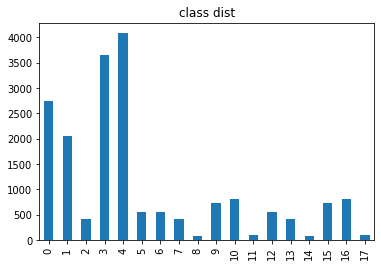

In [9]:
train_data['class'].value_counts().sort_index().plot.bar()
plt.title('class dist')
plt.show()

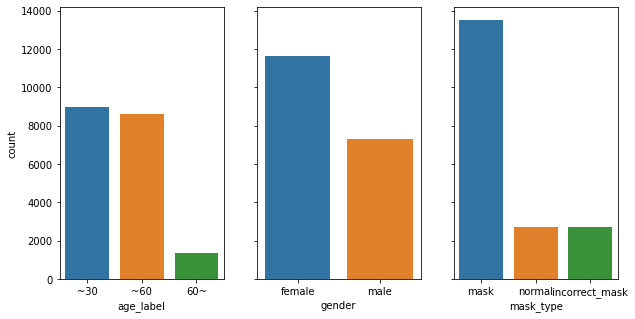

In [13]:
fig, axes = plt.subplots(1,3,figsize=(10,5), sharey=True)
viscol = train_data['mask_type'].map(lambda x: 'mask' if re.search('mask.',x) is not None else x)
sns.countplot(train_data['age_label'], ax=axes[0])
sns.countplot(train_data['gender'], ax=axes[1])
sns.countplot(viscol, ax=axes[2])
axes[0].set_xticklabels(['~30','~60','60~'])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.show()

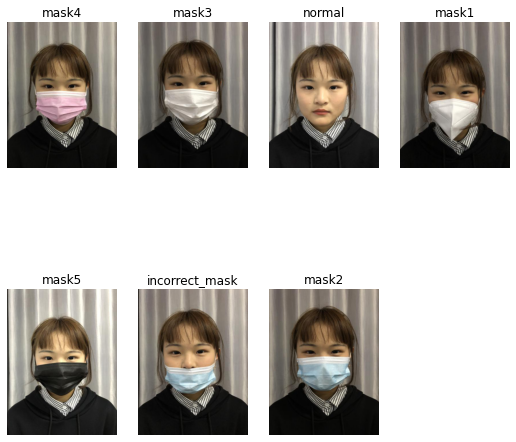

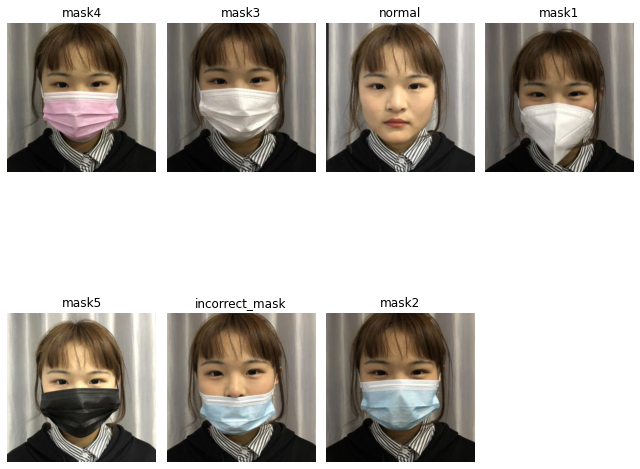

In [19]:
path = train_data['path'].drop_duplicates().sample().values[0]
samples = [i for i in os.listdir(train_images + path)if not i.startswith('.')]

def show_sample(visible_crop=True):
    fig = plt.figure(figsize=(9,9))
    for idx, image_name in enumerate(samples,1):
        ax = fig.add_subplot(2,4,idx)
        image = Image.open(os.path.join(*[train_images, path, image_name]))
        ax.imshow(image)
        ax.set_title(image_name[:-4])
        plt.axis('off')
        
    if visible_crop == True:
        fig = plt.figure(figsize=(9,9))
        for idx, image_name in enumerate(samples,1):
            ax = fig.add_subplot(2,4,idx)
            image = Image.open(os.path.join(*[train_images, path, image_name]))
            image = transforms.CenterCrop((350))(image)
            ax.imshow(image)
            ax.set_title(image_name[:-4])
            plt.axis('off')
show_sample()
plt.tight_layout()
plt.show()

* 한 폴더에 있는 이미지들에서도 밝기 차이가 많이 난다.
* 코스크, 턱스크 뿐만 아니라 눈을 가리고 있는 incorrect_mask도 있어서 face align은 어려울 듯 보임.
* 남자인데 여자로 labeling된 사람 있음.

## Dataset / Dataloader

In [14]:
class MaskedFaceDataset(Dataset):
    def __init__(self, csv_file, folder, transforms=None):
        self.meta = csv_file
        self.transforms = transforms
        self.folder = folder
        
    def __len__(self):
        return len(self.meta)
        
    def __getitem__(self, idx):
        sample = self.meta.loc[idx]
        gender = sample['gender_label']
        age = sample['age_label']
        mask = sample['mask_label']
        label = sample['class']
        image = Image.open(os.path.join(self.folder,sample['detail_path']))
        if self.transforms is not None:
            image = self.transforms(image)
        
        sample = {'image':image.float(), 'labels':{'gender':gender,
                                        'age':age, 'mask':mask,
                                        'label':label}}
        return sample

class MaskedFaceDataset_Test(Dataset):
    def __init__(self, transforms=None):
        pass
        
    def __len__(self):
        pass
        
    def __getitem__(self, idx):
        pass

In [652]:
train_transforms = transforms.Compose([
    transforms.PILToTensor()
])
test_transforms = transforms.Compose([
    transforms.PILToTensor()
])

* normalize 추가
* more aug

In [16]:
torch.cuda.is_available()

True

In [653]:
from sklearn.model_selection import train_test_split

train = train_data.loc[:3]
valid = train_data.loc[:15000]

In [654]:
train_dataset = MaskedFaceDataset(train, train_images, 
                                  transforms=train_transforms)
valid_dataset = MaskedFaceDataset(valid, train_images, 
                                  transforms=train_transforms)

In [655]:
train_dataloader = DataLoader(train_dataset, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, shuffle=False)

* Stratified split으로 변경
* batch_size 등 설정

## Model

In [17]:
class Network(nn.Module):
    def __init__(self):
        self.model = models.resnet18()
        self.model.fc = nn.Linear(in_features=512, 
                             out_features=18, bias=True)
    
    def forward(self, x):
        x = model(x)
        
        return x        

* 다중아웃풋 모델 고려해서 모델 구성 필요

## Train

In [659]:
num_epochs = 1
device = 'cpu'
criterion = torch.nn.CrossEntropyLoss()
model = Network()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0,0
    for batch in train_dataloader:
        image = batch['image'].to(device)
        label = batch['labels']['label'].to(device)
        output = model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(output, 1)
        
        running_loss = loss.item() * image.size(0)
        correct += torch.sum(preds==label)
        
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / len(train_dataloader)
    
    print(f'[EPOCH:{epoch}] | ACC: {epoch_acc} | Loss: {epoch_loss} |')

[EPOCH:0] | ACC: 0.75 | Loss: 0.07219746708869934 |
